# IFM Translation: Celeba2Anime 64x64

In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset, Subset

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import wandb
import sys
sys.path.append("/trinity/home/a.kolesov/EFM/")
from src.models import DDPM, ExponentialMovingAverage
from src.ifm_field import IFM
from src.utils import Config, optimization_manager, random_color

## 1. Base Config

In [2]:
config = Config()

 
config.L = 20. # important parameter
config.SCALE = 10.
config.K =  math.pi/config.L
config.D = math.pi/(2*config.K)
config.device = 'cuda'
config.experiment = 'translation'

config.data = Config()
config.data.name = 'Celeba2Anime'
config.data.name_sets = ['Anime','Female']
config.data.num_channels = 3
config.data.img_resize = 64
config.data.image_size=64
config.data.centered = True
config.DIM = config.data.num_channels*config.data.image_size*config.data.image_size + 1

config.p = Config()
config.p.x_loc = 0.

config.q = Config()
config.q.x_loc = config.L

config.training = Config()
config.training.small_batch_size =64 # important parameter
config.training.batch_size =256      # important parameter
config.training.field_type = "Shifted"
config.training.plan_type = "Optimal"
config.training.field_form = "exponential"
config.training.n_iters = 1_000_000
config.training.sde = 'poisson'
config.training.eval_freq = 1_000
config.training.snapshot_freq = 5_000
config.training.sigma_end = 0.1
config.training.M = 291 # important parameter
config.training.tau = 0.03  
config.training.epsilon = 1e-3 # important parameter
config.training.interpolation = 'Uniform'
config.training.noised_interpolation = True
config.training.noised_interpolation_mltp = 40.
config.training.restrict_M = False
config.training.gamma = 5. # important parameter

config.model  = Config()

config.model = config.model
config.model.name = 'ncsnpp'
config.model.scale_by_sigma = False
config.model.ema_rate = 0.9999
config.model.normalization = 'GroupNorm'
config.model.nonlinearity = 'swish'
config.model.nf = 128
config.model.ch_mult = (1, 2, 2, 2)
config.model.num_res_blocks = 4
config.model.attn_resolutions = (16,)
config.model.resamp_with_conv = True
config.model.conditional = True
config.model.fir = False
config.model.fir_kernel = [1, 3, 3, 1]
config.model.skip_rescale = True
config.model.resblock_type = 'biggan'
config.model.progressive = 'none'
config.model.progressive_input = 'none'
config.model.progressive_combine = 'sum'
config.model.attention_type = 'ddpm'
config.model.init_scale = 0.
config.model.fourier_scale = 16
config.model.embedding_type = 'positional'
config.model.conv_size = 3
config.model.sigma_end = 0.01
config.model.dropout = 0.1

config.optim  = Config()
config.optim.weight_decay = 0
config.optim.optimizer = 'Adam'
config.optim.lr = 2e-4
config.optim.beta1 = 0.9
config.optim.eps = 1e-8 
config.optim.warmup = 5000  
config.optim.grad_clip = 1.

config.ode = Config()
config.ode.gamma = 1e-7
config.ode.step = 0.25

config.sampling = Config()
config.sampling.method = 'ode'
config.sampling.ode_solver = 'rk45'
config.sampling.N = 100
config.sampling.z_max = config.L# - config.training.epsilon
config.sampling.z_min = config.training.epsilon
config.sampling.upper_norm = 3000
config.sampling.z_exp=1
config.sampling.vs = False
config.sampling.visual_iterations=10

## 2. Data

In [3]:
TRANSFORM = torchvision.transforms.Compose([
                #torchvision.transforms.CenterCrop(140),
                torchvision.transforms.Resize((config.data.image_size, config.data.image_size)),
                torchvision.transforms.ToTensor()
            ])


train_set, eval_set = {}, {}
train_loader, eval_loader = {},{}
train_iter,eval_iter = {},{}
for idx,name_set in enumerate(config.data.name_sets):
    
    if idx==0:
        path = f'/trinity/home/a.kolesov/data/{name_set}/'
    else:
        path = f'/trinity/home/a.kolesov/data/Celeba_gender/Dataset/Train/{name_set}'
    train_set[name_set]  =  ImageFolder(path, transform=TRANSFORM)
    
    
    if idx==0:
        path = f'/trinity/home/a.kolesov/data/{name_set}/'
    else:
        path = f'/trinity/home/a.kolesov/data/Celeba_gender/Dataset/Test/{name_set}'
        
    eval_set[name_set]  =  ImageFolder(path, transform=TRANSFORM)
    
    train_loader[name_set] = torch.utils.data.DataLoader(train_set[name_set],
                                                         batch_size=config.training.batch_size,
                                                         shuffle=True)
    
    eval_loader[name_set] =  torch.utils.data.DataLoader(eval_set[name_set], 
                                                         batch_size=config.training.batch_size, 
                                                         shuffle=True)
    
    train_iter[name_set] = iter(train_loader[name_set])
    eval_iter[name_set] = iter(eval_loader[name_set])
                                           


In [287]:
for idx, name_set in enumerate(config.data.name_sets):
    try:
        batch,_ =  next(eval_iter[name_set])
    except StopIteration:
        print('stop')
    else:
        eval_iter[name_set] = iter(eval_loader[name_set])
        batch,_ =  next(eval_iter[name_set])
    batch = batch.to(config.device)

    if idx == 0:
        batch_x = batch
    else:
        batch_y = batch

In [288]:
ifm = IFM(config)
s = ifm.forward_interpolation(batch_x[:64],batch_y[:64])

In [333]:
t = torch.tensor([[20.]])
perturbed_x = batch_y[0].cpu()*(t[:,None,None]/config.L) + (1 - t[:,None,None]/config.L)*batch_x[0].cpu()
           
             
if config.training.noised_interpolation:

    perturbed_x = perturbed_x.reshape(1, config.DIM-1)
    ###################
    gaussian = torch.randn(batch_x.shape[0], config.DIM-1).to('cpu') # torch.Size([b, C*H*W=D])
    unit_gaussian = gaussian / torch.norm(gaussian, p=2, dim=1, keepdim=True) #  torch.Size([b, C*H*W=D])

    #mltp = 2*torch.log(1 - torch.abs(t.squeeze()-self._config.L/2) + self._config.L/2)
    mltp = 1 + torch.cos(2*math.pi/config.L*(t.squeeze()-config.L/2))

    perturbed_x = perturbed_x + config.training.noised_interpolation_mltp*unit_gaussian[0][None,:]*mltp

([], [])

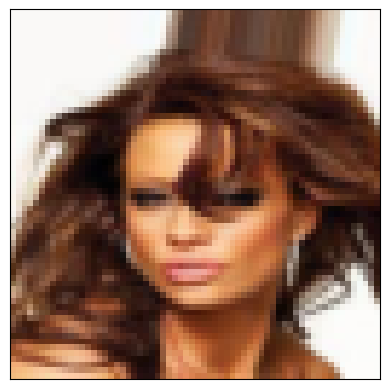

In [334]:
plt.imshow(perturbed_x.view(3,64,64).permute(1,2,0))
plt.xticks([])
plt.yticks([])

In [332]:
perturbed_x.shape

torch.Size([1, 12288])

## 3. Models

In [4]:
net = DDPM(config).to(config.device)
params = net.parameters()
optimizer = torch.optim.Adam(params,
                       lr=config.optim.lr, betas=(config.optim.beta1, 0.999), eps=config.optim.eps,
                       weight_decay=config.optim.weight_decay)

ema = ExponentialMovingAverage(net.parameters(), decay=config.model.ema_rate)
state = dict(optimizer=optimizer, model=net, ema=ema, step=0)
optimize_fn = optimization_manager(config)

In [5]:
net.cpu()
net.load_state_dict(torch.load("../ckpt/Celeba2Anime_L=20.0_sc=10.0_BS_256_SBS=64_plan_Optimal_Int=Uniform_Noise=Truemltp=20.0.pth"))
net.to(config.device);

In [69]:
from src.ode import LearnedImageODESolver
ode_solver = LearnedImageODESolver(net, config)
batch_y,_ = next(train_iter['Female'])

In [72]:
with torch.no_grad():
    sample, traj = ode_solver(torch.cat([(config.L)*torch.ones(batch_y.shape[0],
                                                        device=batch_y.device)[:,None],
                                                         batch_y.view(-1, config.DIM-1)],
                                             dim=1).to(config.device))

In [276]:
torch.save(a_2.cpu(),"../tnsr/C2A_female.pth")

In [277]:
b_2 = sample[[15,37,38,41,44,53,69,76,77,83,88,90,99,101,115,116 ],1:].cpu()

In [279]:
from src.ifm_field import IFM

In [280]:
ifm = IFM(config)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


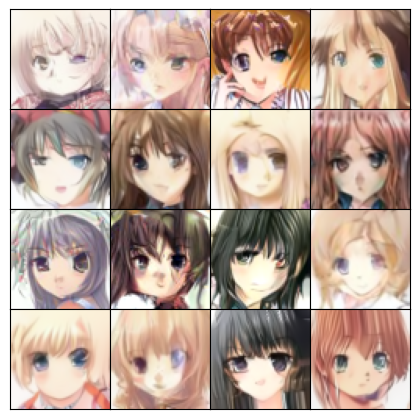

In [285]:
ifm.plota(b_2.reshape(4,4,3,64,64), figsize=4);

## 4. Training

In [14]:
config.name_exp = f"Celeba2Anime_L={config.L}_sc={config.SCALE}_BS_{config.training.batch_size}_\
SBS={config.training.small_batch_size}_plan_{config.training.plan_type}_\
Int={config.training.interpolation}_Noise={config.training.noised_interpolation}\
mltp={config.training.noised_interpolation_mltp}"
#wandb.init(project="IFMTranslationCelebA", name=config.name_exp)

  0%|          | 0/1000001 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for f

KeyboardInterrupt: 

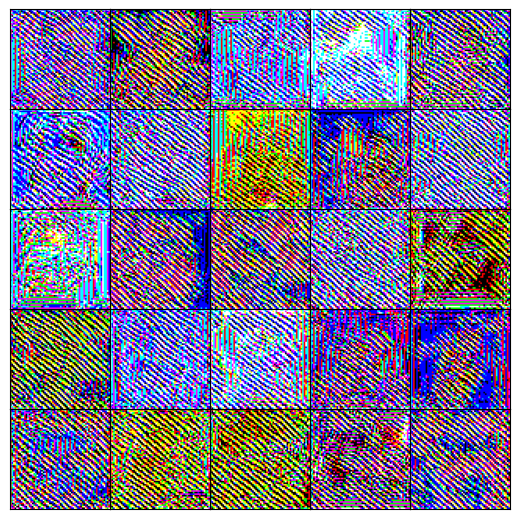

In [15]:
ifm = IFM(config)
net, state = ifm.train(train_loader, eval_loader,
                       net, optimizer, optimize_fn,
                       state)

In [80]:
import zipfile
with zipfile.ZipFile('/trinity/home/a.kolesov/data/summer2winter.zip', 'r') as zip_ref:
    zip_ref.extractall('/trinity/home/a.kolesov/data/summer2winter')